In [310]:
import pickle
import numpy as np
import matplotlib.pylab as plt
import uproot
from sklearn.metrics import confusion_matrix

In [311]:
def return_accuracy(predict1,predict2,validation):
    mass_predict1 = []
    for i in predict1:
        if i <2.5:
            mass_predict1.append(1)
        else:
            mass_predict1.append(4)
    cm=confusion_matrix(validation,mass_predict1)

    mass_predict4 = []
    for i in predict2:
        if i <2.5:
            mass_predict4.append(1)
        else:
            mass_predict4.append(4)
    cm1=confusion_matrix(validation,mass_predict4)
    
    return cm[0][0]/np.sum(cm[0]),cm1[1][1]/np.sum(cm1[1]),np.array(mass_predict1),np.array(mass_predict4)

In [312]:
file = uproot.open('/home/andy/12632.root')
file2 = uproot.open('/home/andy/12633.root')

In [313]:
cut_model = pickle.load((open('cut_model.sav','rb')))
proton_model =  pickle.load((open('proton_best_model.sav','rb')))
iron_model =  pickle.load((open('iron_best_model.sav','rb')))

In [315]:
print(cut_model)
print(proton_model)
print(iron_model)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                       criterion='friedman_mse',
                                                       max_depth=5,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                       random_state=None,
                                                       splitter='best'),
         

In [299]:
S125_1 = np.log10(file['LaputopParams']['s125'].array())
S125_2 = np.log10(file2['LaputopParams']['s125'].array())
A1 = file['CurvatureOnlyParams']['A'].array()
A2 = file2['CurvatureOnlyParams']['A'].array()
D1 = file['CurvatureOnlyParams']['D'].array()
D2 = file2['CurvatureOnlyParams']['D'].array()
beta1 = file['LaputopParams']['beta'].array()
beta2 = file2['LaputopParams']['beta'].array()
zenith1 = file['Laputop']['zenith'].array()
zenith2 = file2['Laputop']['zenith'].array()
chi2_1 = file['CurvatureOnlyParams']['chi2_time'].array()
chi2_2 = file2['CurvatureOnlyParams']['chi2_time'].array()
energy1 = file['MCPrimary']['energy'].array()
energy2 = file2['MCPrimary']['energy'].array()
mass1 = [1 for i in range(len(energy1))]
mass2 = [4 for i in range(len(energy2))]

In [300]:
A = np.append(A1,A2)
D = np.append(D1,D2)
S125 = np.append(S125_1,S125_2)
beta = np.log10(np.append(beta1,beta2))
chi2 = np.log10(np.append(chi2_1,chi2_2))
zenith = np.cos(np.append(zenith1,zenith2))
zenith_new = np.append(zenith1,zenith2)*180/np.pi
mass = np.append(mass1,mass2)
energy = np.append(energy1,energy2)

In [301]:
A = A[np.isfinite(chi2)]
D = D[np.isfinite(chi2)]
S125 = S125[np.isfinite(chi2)]
beta = beta[np.isfinite(chi2)]
chi2_new = chi2[np.isfinite(chi2)]
zenith = zenith[np.isfinite(chi2)]
zenith_new = zenith_new[np.isfinite(chi2)]
mass = mass[np.isfinite(chi2)]
energy = np.log10(energy[np.isfinite(chi2)])

In [302]:
mask = cut_model.predict(list(zip(S125,A,zenith,chi2_new)))

In [303]:
mask_new = []
for i in mask:
    if i < 0.5:
        mask_new.append(False)
    else:
        mask_new.append(True)

In [304]:
input_variable2_old = np.array([np.append(i,j) for i,j in zip(D[mask_new],beta[mask_new])])
output_new_old = mass[mask_new]
energy_new = energy[mask_new]

In [305]:
prediction1 = proton_model.predict(input_variable2_old)
prediction2 = iron_model.predict(input_variable2_old)
print(return_accuracy(prediction1,prediction2,output_new_old))

(0.9401143421214988, 0.8861505896583006, array([4, 1, 1, ..., 1, 1, 1]), array([4, 1, 4, ..., 4, 4, 4]))


In [306]:
data1 = np.array(list(zip(input_variable2_old,output_new_old)))
data2 = np.array(energy_new)
array_split = np.array_split(sorted(list(zip(data1,data2)),key=lambda x:x[1]),1)

In [307]:
x = []
y_proton = []
y_iron = []
for i in array_split:
    energy = list(zip(*i))[1]
    mass = list(zip(*list(zip(*i))[0]))[1]
    data = list(zip(*list(zip(*i))[0]))[0]
    prediction1 = proton_model.predict(data)
    prediction2 = iron_model.predict(data)
    prediction = (prediction1+prediction2)/2.0
    output_prediction = []
    for i in prediction:
        if i<2.5:
            output_prediction.append(1)
        elif i >= 2.5:
            output_prediction.append(4)
        else:
            output_prediction.append(0)
    
    #acc_proton,acc_iron,something1,something2 = return_accuracy(prediction1,prediction2,mass)
    print(confusion_matrix(output_prediction,mass))
    x.append((max(energy)+min(energy))/2)

[[12086  5446]
 [12227 14396]]


In [308]:
print(9899/(9899+4632),15209/(15209+14404))

0.6812332255178584 0.5135920035119711


ValueError: x and y must be the same size

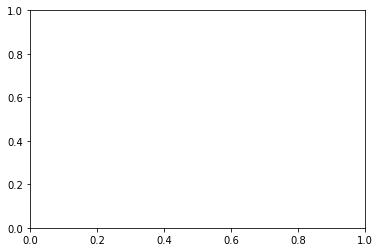

In [309]:
plt.scatter(x,y_proton)
plt.xlabel('Energy')
plt.ylabel('Accuracy_Proton')
#plt.savefig('Proton_accuracy_energy')

In [ ]:
plt.scatter(x,y_iron)
plt.xlabel('Energy')
plt.ylabel('Accuracy Iron')
#plt.savefig('Iron_accuracy_energy')

In [ ]:
plt.hist(zenith_new[mask_new],bins=100)
plt.show()